# Imports

In [1]:
import os
import sys

import torch
import yaml

sys.path.append(os.path.abspath(os.path.join('..')))

import local_datasets

import init_training

from codecarbon import EmissionsTracker

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import time
from IPython.display import clear_output

from torchinfo import summary

import pandas as pd

import numpy as np

import tracemalloc

import torch
from torchvision.transforms import functional as TF

# Cfg

In [2]:
# change working directory if not /home/mappel/Dynaphos/viseon
if os.getcwd().split("/")[-1] != "viseon":
    os.chdir("/home/mappel/Dynaphos/viseon")

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

experiment_yaml = [ './_config/exp1-snellius/128x128_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin16x16_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov16x16_contrained_boundary.yaml']


# load configs into dict
config = [load_config(yaml_file) for yaml_file in experiment_yaml]
config = {key: value for key, value in zip(['128x128', '64x64lin', '64x64fov', '32x32fov', '32x32lin', '16x16lin', '16x16fov'], config)}

In [4]:
experiments = ['128x128', '64x64lin', '64x64fov', '32x32fov', '32x32lin', '16x16lin', '16x16fov']

summaries = {}

for experiment in experiments:
    cfg = config[experiment]
    testset = local_datasets.get_lapa_dataset(cfg, split='test')
    models = init_training.get_models(cfg)

    encoder = models['encoder']

    encoder.load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
    encoder.eval()
    encoder.to('cuda')

    # based on cfg
    input_size = (1, 3, cfg['imsize'][0], cfg['imsize'][1])

    summary_ = summary(encoder, input_size=input_size)
    summaries[experiment] = summary_

In [5]:
# show one summary
print(summaries['128x128'])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1024]                 --
├─E2E_Encoder: 1-1                       [1, 1024]                 --
│    └─Sequential: 2-1                   [1, 1024]                 --
│    │    └─Conv2d: 3-1                  [1, 8, 128, 128]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 128, 128]          16
│    │    └─LeakyReLU: 3-3               [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-4                  [1, 16, 128, 128]         1,152
│    │    └─BatchNorm2d: 3-5             [1, 16, 128, 128]         32
│    │    └─LeakyReLU: 3-6               [1, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 32, 64, 64]           4,608
│    │    └─BatchNorm2d: 3-9             [1, 32, 64, 64]           64
│    │    └─LeakyReLU: 3-10              [1, 32, 64, 64]           --
│    │  

In [6]:
summaries['128x128']

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1024]                 --
├─E2E_Encoder: 1-1                       [1, 1024]                 --
│    └─Sequential: 2-1                   [1, 1024]                 --
│    │    └─Conv2d: 3-1                  [1, 8, 128, 128]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 128, 128]          16
│    │    └─LeakyReLU: 3-3               [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-4                  [1, 16, 128, 128]         1,152
│    │    └─BatchNorm2d: 3-5             [1, 16, 128, 128]         32
│    │    └─LeakyReLU: 3-6               [1, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 32, 64, 64]           4,608
│    │    └─BatchNorm2d: 3-9             [1, 32, 64, 64]           64
│    │    └─LeakyReLU: 3-10              [1, 32, 64, 64]           --
│    │  

In [6]:
# Foveated compression memory and mult-adds computation
import components.RetinalCompression as RetinalCompressionModule 
ret = RetinalCompressionModule.RetinalCompression()

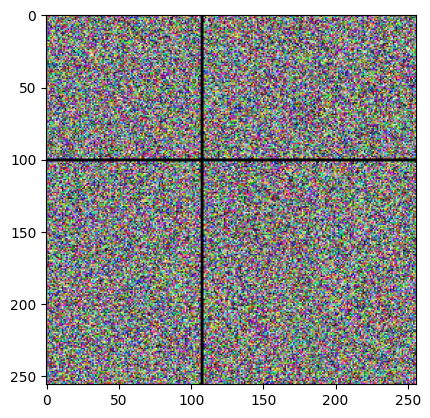

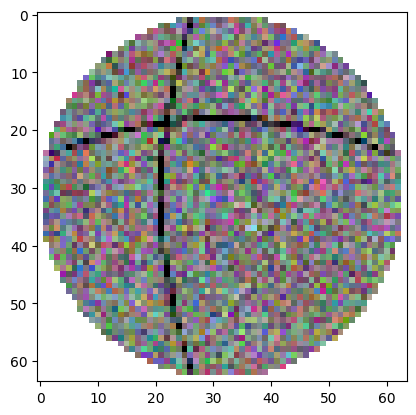

In [7]:
# random test image of 256x256 np array
image = np.random.rand(256,256,3)
# couple of lines
image[100:102] = 0
image[:, 107:109] = 0
image = image*255
# make int type
image = image.astype(np.uint8)
compressed = ret.single(image=image,fov=7, out_size=64, inv=0, type=0, show=0, masking=1, series=0, masktype=1)

# show image and compressed
plt.imshow(image)
plt.show()

plt.imshow(compressed)
plt.show()


In [22]:
def get_memory_usage(image, out_size=64, series=0, initialize=True):
    if initialize:
        # Initialize the module
        ret = RetinalCompressionModule.RetinalCompression()
    else:
        # Initialize the module
        ret = RetinalCompressionModule.RetinalCompression()
        compressed = ret.single(
            image=image,
            fov=7,
            out_size=out_size,
            inv=0,
            type=0,
            show=0,
            masking=1,
            series=series,
            masktype=1
        )


    # Start memory tracking
    tracemalloc.start()
    # Call the function
    compressed = ret.single(
        image=image,
        fov=7,
        out_size=out_size,
        inv=0,
        type=0,
        show=0,
        masking=1,
        series=series,
        masktype=1
    )
        # Measure memory usage
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return peak

# Test the function
memory_64_foveated = get_memory_usage(image, out_size=64, series=1, initialize=False)
memory_32_foveated = get_memory_usage(image, out_size=32, series=1, initialize=False)
memory_16_foveated = get_memory_usage(image, out_size=16, series=1, initialize=False)

In [153]:
# Compare this to nearest neighbor downsampling for every image size

# Define the nearest-neighbor downsampling function
def nearest_neighbor_downsampling(image_tensor, output_size):
    """
    Perform nearest-neighbor downsampling on an input tensor.
    
    Parameters:
    - image_tensor: Input tensor (e.g., shape [C, H, W]).
    - output_size: Desired output size (tuple of height, width).
    
    Returns:
    - downsampled_tensor: Downsampled tensor.
    """
    return TF.resize(image_tensor, size=output_size, interpolation=TF.InterpolationMode.BILINEAR)


# Create a random tensor to simulate an input image
input_tensor = torch.rand(1, 3, 256, 256)  # Batch size 1, 3 channels, 256x256 image

def memory_nn(input_tensor, out_size=64):
    # Start memory tracking
    tracemalloc.start()
    # Call the function
    downsampled_tensor = nearest_neighbor_downsampling(input_tensor, output_size=(out_size, out_size))
    # Measure memory usage
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

# Test the function for 128x128, 64x64, 32x32, and 16x16 output sizes
memory_128_nn = memory_nn(input_tensor, out_size=128)
memory_64_nn = memory_nn(input_tensor, out_size=64)
memory_32_nn = memory_nn(input_tensor, out_size=32)
memory_16_nn = memory_nn(input_tensor, out_size=16)

In [154]:
# calculate multadds for bilinear downsampling
def get_multadds(image_tensor, output_size):
    """
    Calculate the number of multiply-add operations for bilinear downsampling.
    
    Parameters:
    - image_tensor: Input tensor (e.g., shape [C, H, W]).
    - output_size: Desired output size (tuple of height, width).
    
    Returns:
    - multadds: Number of multiply-add operations.
    """
    # Get the input size
    _, _, input_height, input_width = image_tensor.shape
    # Get the output size
    output_height, output_width = output_size
    # Calculate the number of multiply-add operations
    multadds = 2 * input_height * input_width * output_height * output_width
    return multadds

# Test the function for 128x128, 64x64, 32x32, and 16x16 output sizes
multadds_128_nn = get_multadds(input_tensor, output_size=(128, 128))
multadds_64_nn = get_multadds(input_tensor, output_size=(64, 64))
multadds_32_nn = get_multadds(input_tensor, output_size=(32, 32))
multadds_16_nn = get_multadds(input_tensor, output_size=(16, 16))


In [155]:
# now compare multadds for 64x64, 32x32, 16x16

def calculate_multadds(image, out_size=64, series=0):
    ret = RetinalCompressionModule.RetinalCompression()
    compressed = ret.single(
            image=image,
            fov=7,
            out_size=out_size,
            inv=0,
            type=0,
            show=0,
            masking=1,
            series=series,
            masktype=1
        )

    # Create a global counter for operations
    operation_counter = {"add": 0, "mul": 0}

    # Save original NumPy functions
    original_add = np.add
    original_mul = np.multiply

    def add_wrapper(x, y, *args, **kwargs):
        operation_counter["add"] += x.size if hasattr(x, "size") else 1  # Avoid np.size
        return original_add(x, y, *args, **kwargs)

    def mul_wrapper(x, y, *args, **kwargs):
        operation_counter["mul"] += x.size if hasattr(x, "size") else 1  # Avoid np.size
        return original_mul(x, y, *args, **kwargs)

    # Define a context manager to temporarily replace NumPy functions
    from contextlib import contextmanager

    @contextmanager
    def override_numpy_operations():
        try:
            np.add = add_wrapper
            np.multiply = mul_wrapper
            yield
        finally:
            np.add = original_add
            np.multiply = original_mul

    # Run the function with NumPy overrides in place
    image = np.random.rand(256, 256, 3)
    image[100:102] = 0
    image[:, 107:109] = 0
    image = image * 255
    image = image.astype(np.uint8)

    operation_counter = {"add": 0, "mul": 0}  # Reset counters

    # Use the context manager to override NumPy operations
    with override_numpy_operations():
        compressed = ret.single(
            image=image,
            fov=7,
            out_size=out_size,
            inv=0,
            type=0,
            show=0,
            masking=1,
            series=series,
            masktype=1
        )

    # Output operation counts
    # configuration
    print(f"Configuration: {out_size}x{out_size}")
    print(f"Additions: {operation_counter['add']}")
    print(f"Multiplications: {operation_counter['mul']}")
    # total
    print(f"Total: {operation_counter['add'] + operation_counter['mul']}")
    print()
    return operation_counter['add'] + operation_counter['mul']

# Test the function for 64x64, 32x32, and 16x16 output sizes
multadds_64_foveated = calculate_multadds(image, out_size=64, series=1)
multadds_32_foveated = calculate_multadds(image, out_size=32, series=1)
multadds_16_foveated = calculate_multadds(image, out_size=16, series=1)
# multadds_128_nn = 0
# multadds_64_nn = 0
# multadds_32_nn = 0
# multadds_16_nn = 0

Configuration: 64x64
Additions: 12288
Multiplications: 12288
Total: 24576

Configuration: 32x32
Additions: 3072
Multiplications: 3072
Total: 6144

Configuration: 16x16
Additions: 768
Multiplications: 768
Total: 1536



In [28]:
summaries['128x128'].total_mult_adds

122964624

In [156]:
# Put all results in a df
df = pd.DataFrame({
    "Configuration": ["128x128 (NN)", "64x64 (NN)", "64x64 (Fov)", "32x32 (NN)", "32x32 (Fov)", "16x16 (NN)", "16x16 (Fov)"],
    "Total Parameters": [summaries['128x128'].total_params, summaries['64x64lin'].total_params, summaries['64x64fov'].total_params, summaries['32x32lin'].total_params, summaries['32x32fov'].total_params, summaries['16x16lin'].total_params, summaries['16x16fov'].total_params],
    "Memory (Compression)": [memory_128_nn, memory_64_nn, memory_64_foveated, memory_32_nn, memory_32_foveated, memory_16_nn, memory_16_foveated],
    "Memory (Params Size)": [summaries['128x128'].total_param_bytes, summaries['64x64lin'].total_param_bytes, summaries['64x64fov'].total_param_bytes, summaries['32x32lin'].total_param_bytes, summaries['32x32fov'].total_param_bytes, summaries['16x16lin'].total_param_bytes, summaries['16x16fov'].total_param_bytes],
    "Memory (Forward/Backward Pass)": [summaries['128x128'].total_output_bytes, summaries['64x64lin'].total_output_bytes, summaries['64x64fov'].total_output_bytes, summaries['32x32lin'].total_output_bytes, summaries['32x32fov'].total_output_bytes, summaries['16x16lin'].total_output_bytes, summaries['16x16fov'].total_output_bytes],
    "Estimated Total Memory Size": [summaries['128x128'].total_output_bytes + summaries['128x128'].total_param_bytes + memory_128_nn, summaries['64x64lin'].total_output_bytes + summaries['64x64lin'].total_param_bytes + memory_64_nn, summaries['64x64fov'].total_output_bytes + summaries['64x64fov'].total_param_bytes + memory_64_foveated, summaries['32x32lin'].total_output_bytes + summaries['32x32lin'].total_param_bytes + memory_32_nn, summaries['32x32fov'].total_output_bytes + summaries['32x32fov'].total_param_bytes + memory_32_foveated, summaries['16x16lin'].total_output_bytes + summaries['16x16lin'].total_param_bytes + memory_16_nn, summaries['16x16fov'].total_output_bytes + summaries['16x16fov'].total_param_bytes + memory_16_foveated],
    "Mult-Adds (Compression)": [multadds_128_nn, multadds_64_nn, multadds_64_foveated, multadds_32_nn, multadds_32_foveated, multadds_16_nn, multadds_16_foveated],
    "Mult-Adds (Inference)": [summaries['128x128'].total_mult_adds, summaries['64x64lin'].total_mult_adds, summaries['64x64fov'].total_mult_adds, summaries['32x32lin'].total_mult_adds, summaries['32x32fov'].total_mult_adds, summaries['16x16lin'].total_mult_adds, summaries['16x16fov'].total_mult_adds],
    "Total Mult-Adds": [summaries['128x128'].total_mult_adds + multadds_128_nn, summaries['64x64lin'].total_mult_adds + multadds_64_nn, summaries['64x64fov'].total_mult_adds + multadds_64_foveated, summaries['32x32lin'].total_mult_adds + multadds_32_nn, summaries['32x32fov'].total_mult_adds + multadds_32_foveated, summaries['16x16lin'].total_mult_adds + multadds_16_nn, summaries['16x16fov'].total_mult_adds + multadds_16_foveated]
})

df

,Configuration,Total Parameters,Memory (Compression),Memory (Params Size),Memory (Forward/Backward Pass),Estimated Total Memory Size,Mult-Adds (Compression),Mult-Adds (Inference),Total Mult-Adds
0,128x128 (NN),1134969,602,4539876,12861440,17401918,2147483648,122964624,2270448272
1,64x64 (NN),348537,472,1394148,3221504,4616124,536870912,30742416,567613328
2,64x64 (Fov),348537,1862363,1394148,3221504,6478015,24576,30742416,30766992
3,32x32 (NN),151929,472,607716,811520,1419708,134217728,7686864,141904592
4,32x32 (Fov),151929,1645307,607716,811520,3064543,6144,7686864,7693008
5,16x16 (NN),102777,472,411108,209024,620604,33554432,1922976,35477408
6,16x16 (Fov),102777,1591595,411108,209024,2211727,1536,1922976,1924512


In [157]:
df_units = df.copy()
# make memory units human readable, change to MB and round
# make multadds in the millions

df_units["Memory (Compression)"] = df_units["Memory (Compression)"] / 1024 / 1024
df_units["Memory (Params Size)"] = df_units["Memory (Params Size)"] / 1024 / 1024
df_units["Memory (Forward/Backward Pass)"] = df_units["Memory (Forward/Backward Pass)"] / 1024 / 1024
df_units["Estimated Total Memory Size"] = df_units["Estimated Total Memory Size"] / 1024 / 1024
df_units["Mult-Adds (Compression)"] = df_units["Mult-Adds (Compression)"] / 1000000
df_units["Mult-Adds (Inference)"] = df_units["Mult-Adds (Inference)"] / 1000000
df_units["Total Mult-Adds"] = df_units["Total Mult-Adds"] / 1000000

# Round and add units
df_units = df_units.round(4)
df_units["Memory (Compression)"] = df_units["Memory (Compression)"].astype(str) + " MB"
df_units["Memory (Params Size)"] = df_units["Memory (Params Size)"].astype(str) + " MB"
df_units["Memory (Forward/Backward Pass)"] = df_units["Memory (Forward/Backward Pass)"].astype(str) + " MB"
df_units["Estimated Total Memory Size"] = df_units["Estimated Total Memory Size"].astype(str) + " MB"
df_units["Mult-Adds (Compression)"] = df_units["Mult-Adds (Compression)"].astype(str) + " M"
df_units["Mult-Adds (Inference)"] = df_units["Mult-Adds (Inference)"].astype(str) + " M"
df_units["Total Mult-Adds"] = df_units["Total Mult-Adds"].astype(str) + " M"

df_units


,Configuration,Total Parameters,Memory (Compression),Memory (Params Size),Memory (Forward/Backward Pass),Estimated Total Memory Size,Mult-Adds (Compression),Mult-Adds (Inference),Total Mult-Adds
0,128x128 (NN),1134969,0.0006 MB,4.3296 MB,12.2656 MB,16.5958 MB,2147.4836 M,122.9646 M,2270.4483 M
1,64x64 (NN),348537,0.0005 MB,1.3296 MB,3.0723 MB,4.4023 MB,536.8709 M,30.7424 M,567.6133 M
2,64x64 (Fov),348537,1.7761 MB,1.3296 MB,3.0723 MB,6.1779 MB,0.0246 M,30.7424 M,30.767 M
3,32x32 (NN),151929,0.0005 MB,0.5796 MB,0.7739 MB,1.3539 MB,134.2177 M,7.6869 M,141.9046 M
4,32x32 (Fov),151929,1.5691 MB,0.5796 MB,0.7739 MB,2.9226 MB,0.0061 M,7.6869 M,7.693 M
5,16x16 (NN),102777,0.0005 MB,0.3921 MB,0.1993 MB,0.5919 MB,33.5544 M,1.923 M,35.4774 M
6,16x16 (Fov),102777,1.5179 MB,0.3921 MB,0.1993 MB,2.1093 MB,0.0015 M,1.923 M,1.9245 M


In [158]:
# Split in Memory and Mult-Adds + total parameters
df_memory = df_units[["Configuration", "Memory (Compression)", "Memory (Params Size)", "Memory (Forward/Backward Pass)", "Estimated Total Memory Size"]]
df_multadds = df_units[["Configuration", "Total Parameters", "Mult-Adds (Compression)", "Mult-Adds (Inference)", "Total Mult-Adds"]]


In [142]:
def df_to_latex_table(df, caption, label):
    """
    Convert a pandas DataFrame to a LaTeX table format.

    Parameters:
    - df: pandas DataFrame
    - caption: str, the caption of the table
    - label: str, the label of the table for referencing in LaTeX

    Returns:
    - str: LaTeX table code
    """
    latex_table = "\\begin{table*}[h!]\n"
    latex_table += "\\centering\n"
    latex_table += "\\begin{tabular}{|l|" + "c|" * (len(df.columns) - 1) + "}\n"
    latex_table += "\\hline\n"
    
    # Add column headers
    headers = " & ".join([f"\\textbf{{{col}}}" for col in df.columns])
    latex_table += f"{headers} \\\\ \\hline\n"
    
    # Add data rows
    for _, row in df.iterrows():
        row_data = " & ".join([str(cell) for cell in row])
        latex_table += f"{row_data} \\\\ \\hline\n"
    
    # Add caption and label
    latex_table += "\\end{tabular}\n"
    latex_table += f"\\caption{{{caption}}}\n"
    latex_table += f"\\label{{{label}}}\n"
    latex_table += "\\end{table*}"
    
    return latex_table


In [143]:
# Example usage
# Assuming `df_converted` is your DataFrame
latex_code = df_to_latex_table(
    df_memory,
    caption="Comparison of network size and computational efficiency for different configurations.",
    label="tab:network_efficiency"
)

print(latex_code)

\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
\textbf{Configuration} & \textbf{Memory (Compression)} & \textbf{Memory (Params Size)} & \textbf{Memory (Forward/Backward Pass)} & \textbf{Estimated Total Memory Size} \\ \hline
128x128 (NN) & 0.0005 MB & 4.3296 MB & 12.2656 MB & 16.5956 MB \\ \hline
64x64 (NN) & 0.0005 MB & 1.3296 MB & 3.0723 MB & 4.4023 MB \\ \hline
64x64 (Fov) & 1.7761 MB & 1.3296 MB & 3.0723 MB & 6.1779 MB \\ \hline
32x32 (NN) & 0.0005 MB & 0.5796 MB & 0.7739 MB & 1.3539 MB \\ \hline
32x32 (Fov) & 1.5691 MB & 0.5796 MB & 0.7739 MB & 2.9226 MB \\ \hline
16x16 (NN) & 0.0005 MB & 0.3921 MB & 0.1993 MB & 0.5919 MB \\ \hline
16x16 (Fov) & 1.5179 MB & 0.3921 MB & 0.1993 MB & 2.1093 MB \\ \hline
\end{tabular}
\caption{Comparison of network size and computational efficiency for different configurations.}
\label{tab:network_efficiency}
\end{table*}


In [144]:
# Example usage
# Assuming `df_converted` is your DataFrame
latex_code = df_to_latex_table(
    df_multadds,
    caption="Comparison of network size and computational efficiency for different configurations.",
    label="tab:network_efficiency"
)

print(latex_code)

\begin{table*}[h!]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
\textbf{Configuration} & \textbf{Total Parameters} & \textbf{Mult-Adds (Compression)} & \textbf{Mult-Adds (Inference)} & \textbf{Total Mult-Adds} \\ \hline
128x128 (NN) & 1134969 & 0.0 M & 122.9646 M & 122.9646 M \\ \hline
64x64 (NN) & 348537 & 0.0 M & 30.7424 M & 30.7424 M \\ \hline
64x64 (Fov) & 348537 & 0.0246 M & 30.7424 M & 30.767 M \\ \hline
32x32 (NN) & 151929 & 0.0 M & 7.6869 M & 7.6869 M \\ \hline
32x32 (Fov) & 151929 & 0.0061 M & 7.6869 M & 7.693 M \\ \hline
16x16 (NN) & 102777 & 0.0 M & 1.923 M & 1.923 M \\ \hline
16x16 (Fov) & 102777 & 0.0015 M & 1.923 M & 1.9245 M \\ \hline
\end{tabular}
\caption{Comparison of network size and computational efficiency for different configurations.}
\label{tab:network_efficiency}
\end{table*}


In [145]:
# Save the tables to a LaTeX file
df_memory.to_latex("memory_table.tex", index=False)
df_multadds.to_latex("multadds_table.tex", index=False)

In [146]:
import seaborn as sns

In [159]:
# Plot memory and mult-adds
# x axis labels
experiments = ['64x64', '32x32', '16x16']
foveation_types = ['foveated', 'non-foveated']

# Use data from previous cell and split into 64x64lin, 32x32lin, 16x16lin, and 64x64fov, 32x32fov, 16x16fov
baseline = df[df['Configuration'].str.contains('128x128')].copy()

data_NN = df[df['Configuration'].str.contains('NN')].copy()
data_fov = df[df['Configuration'].str.contains('Fov')].copy()

# Modify the 'Experiment' column for each dataset
data_NN['Configuration'] = data_NN['Configuration'].str.replace(' (NN)', '')
data_fov['Configuration'] = data_fov['Configuration'].str.replace(' (Fov)', '')

# Define custom positions for each input size on a linear scale
input_size_positions = {'64x64': 2, '32x32': 3, '16x16': 4}

# Map the 'Experiment' column to these positions
data_NN['Input Size Position'] = data_NN['Configuration'].replace(input_size_positions)
data_NN = data_NN[data_NN['Configuration'] != '128x128']
data_fov['Input Size Position'] = data_fov['Configuration'].replace(input_size_positions)

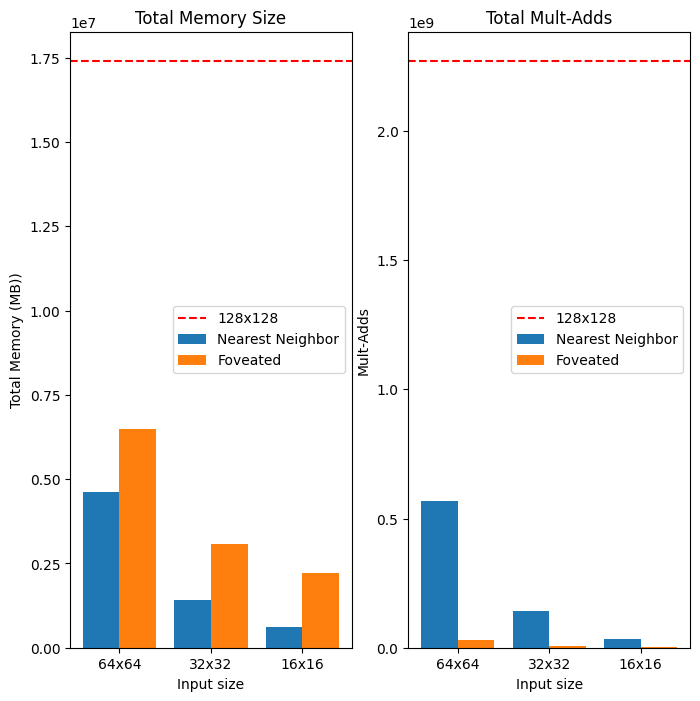

In [160]:
# Create bar plots for the aggregated data
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Total Memory plot the bars side by side
axes[0].bar(data_NN['Input Size Position'] - 0.2, data_NN['Estimated Total Memory Size'], width=0.4, label="Nearest Neighbor")
axes[0].bar(data_fov['Input Size Position'] + 0.2, data_fov['Estimated Total Memory Size'], width=0.4, label="Foveated")
axes[0].axhline(y=baseline['Estimated Total Memory Size'].values[0], color='r', linestyle='--', label='128x128')
axes[0].legend()
axes[0].set_title('Total Memory Size')
axes[0].set_ylabel('Total Memory (MB))')
axes[0].set_xlabel('Input size')
axes[0].set_xticks(list(input_size_positions.values()))
axes[0].set_xticklabels(list(input_size_positions.keys()))

# Total Mult-Adds plot the bars side by side
axes[1].bar(data_NN['Input Size Position'] - 0.2, data_NN['Total Mult-Adds'], width=0.4, label="Nearest Neighbor")
axes[1].bar(data_fov['Input Size Position'] + 0.2, data_fov['Total Mult-Adds'], width=0.4, label="Foveated")
axes[1].axhline(y=baseline['Total Mult-Adds'].values[0], color='r', linestyle='--', label='128x128')
axes[1].legend()
axes[1].set_title('Total Mult-Adds')
axes[1].set_ylabel('Mult-Adds')
axes[1].set_xlabel('Input size')
axes[1].set_xticks(list(input_size_positions.values()))
axes[1].set_xticklabels(list(input_size_positions.keys()))

plt.show()

In [161]:
baseline

,Configuration,Total Parameters,Memory (Compression),Memory (Params Size),Memory (Forward/Backward Pass),Estimated Total Memory Size,Mult-Adds (Compression),Mult-Adds (Inference),Total Mult-Adds
0,128x128 (NN),1134969,602,4539876,12861440,17401918,2147483648,122964624,2270448272


In [162]:
# convert data_NN and data_fov to MB and M
data_NN_form = data_NN.copy()
data_fov_form = data_fov.copy()
baseline_form = baseline.copy()

data_NN_form["Estimated Total Memory Size"] = data_NN_form["Estimated Total Memory Size"] / 1024 / 1024
data_fov_form["Estimated Total Memory Size"] = data_fov_form["Estimated Total Memory Size"] / 1024 / 1024
data_NN_form["Memory (Compression)"] = data_NN_form["Memory (Compression)"] / 1024 / 1024
data_fov_form["Memory (Compression)"] = data_fov_form["Memory (Compression)"] / 1024 / 1024
data_NN_form["Memory (Params Size)"] = data_NN_form["Memory (Params Size)"] / 1024 / 1024
data_fov_form["Memory (Params Size)"] = data_fov_form["Memory (Params Size)"] / 1024 / 1024
data_NN_form["Memory (Forward/Backward Pass)"] = data_NN_form["Memory (Forward/Backward Pass)"] / 1024 / 1024
data_fov_form["Memory (Forward/Backward Pass)"] = data_fov_form["Memory (Forward/Backward Pass)"] / 1024 / 1024
data_NN_form["Mult-Adds (Compression)"] = data_NN_form["Mult-Adds (Compression)"] / 1000000
data_fov_form["Mult-Adds (Compression)"] = data_fov_form["Mult-Adds (Compression)"] / 1000000
data_NN_form["Mult-Adds (Inference)"] = data_NN_form["Mult-Adds (Inference)"] / 1000000
data_fov_form["Mult-Adds (Inference)"] = data_fov_form["Mult-Adds (Inference)"] / 1000000
data_NN_form["Total Mult-Adds"] = data_NN_form["Total Mult-Adds"] / 1000000
data_fov_form["Total Mult-Adds"] = data_fov_form["Total Mult-Adds"] / 1000000

baseline_form["Estimated Total Memory Size"] = baseline_form["Estimated Total Memory Size"] / 1024 / 1024
baseline_form["Memory (Compression)"] = baseline_form["Memory (Compression)"] / 1024 / 1024
baseline_form["Memory (Params Size)"] = baseline_form["Memory (Params Size)"] / 1024 / 1024
baseline_form["Memory (Forward/Backward Pass)"] = baseline_form["Memory (Forward/Backward Pass)"] / 1024 / 1024
baseline_form["Mult-Adds (Compression)"] = baseline_form["Mult-Adds (Compression)"] / 1000000
baseline_form["Mult-Adds (Inference)"] = baseline_form["Mult-Adds (Inference)"] / 1000000
baseline_form["Total Mult-Adds"] = baseline_form["Total Mult-Adds"] / 1000000


In [163]:
data_NN

,Configuration,Total Parameters,Memory (Compression),Memory (Params Size),Memory (Forward/Backward Pass),Estimated Total Memory Size,Mult-Adds (Compression),Mult-Adds (Inference),Total Mult-Adds,Input Size Position
1,64x64,348537,472,1394148,3221504,4616124,536870912,30742416,567613328,2
3,32x32,151929,472,607716,811520,1419708,134217728,7686864,141904592,3
5,16x16,102777,472,411108,209024,620604,33554432,1922976,35477408,4


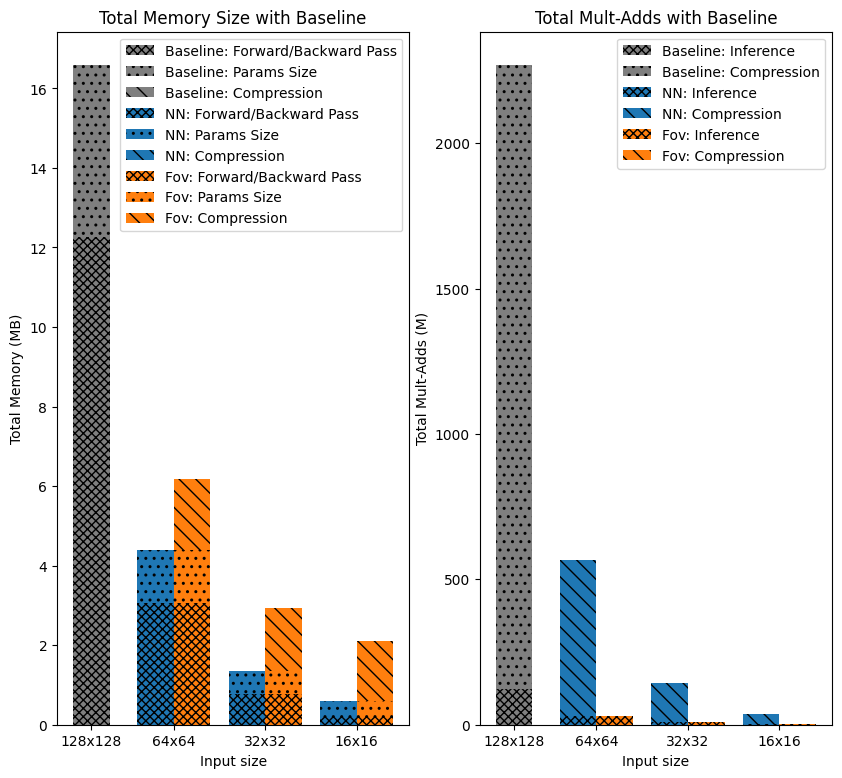

In [164]:
# Make this plot but now stack the different type of memories: compression, params, forward/backward pass
# Create bar plots for the aggregated data
fig, axes = plt.subplots(1, 2, figsize=(10, 9))  # Single plot for simplicity

# Define hatches for texture
fbpass_hatch = "xxxx"
params_hatch = '..'
compression_hatch = '\\\\'

color_NN = 'tab:blue'
color_fov = 'tab:orange'
color_baseline = 'tab:gray'

# Baseline bar position
baseline_position = 1.1

# Add baseline as a stacked bar
axes[0].bar(
    baseline_position, baseline_form['Memory (Forward/Backward Pass)'].values[0],
    width=0.4, color=color_baseline, hatch=fbpass_hatch, label="Baseline: Forward/Backward Pass"
)
axes[0].bar(
    baseline_position, baseline_form['Memory (Params Size)'].values[0],
    width=0.4, color=color_baseline, hatch=params_hatch,
    bottom=baseline_form['Memory (Forward/Backward Pass)'].values[0], label="Baseline: Params Size"
)
axes[0].bar(
    baseline_position, baseline_form['Memory (Compression)'].values[0],
    width=0.4, color=color_baseline, hatch=compression_hatch,
    bottom=baseline_form['Memory (Forward/Backward Pass)'].values[0] + baseline_form['Memory (Params Size)'].values[0],
    label="Baseline: Compression"
)

# Plot Nearest Neighbor (NN) bars with compression on top
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Forward/Backward Pass)'], width=0.4, color=color_NN, hatch=fbpass_hatch, label="NN: Forward/Backward Pass")
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Params Size)'], width=0.4, color=color_NN, hatch=params_hatch, 
         bottom=data_NN_form['Memory (Forward/Backward Pass)'], label="NN: Params Size")
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Compression)'], width=0.4, color=color_NN, hatch=compression_hatch, 
         bottom=data_NN_form['Memory (Forward/Backward Pass)'] + data_NN_form['Memory (Params Size)'], label="NN: Compression")

# Plot Foveated (Fov) bars with compression on top
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Forward/Backward Pass)'], width=0.4, color=color_fov, hatch=fbpass_hatch, label="Fov: Forward/Backward Pass")
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Params Size)'], width=0.4, color=color_fov, hatch=params_hatch, 
         bottom=data_fov_form['Memory (Forward/Backward Pass)'], label="Fov: Params Size")
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Compression)'], width=0.4, color=color_fov, hatch=compression_hatch, 
         bottom=data_fov_form['Memory (Forward/Backward Pass)'] + data_fov_form['Memory (Params Size)'], label="Fov: Compression")

# Formatting
axes[0].legend()
axes[0].set_title('Total Memory Size with Baseline')
axes[0].set_ylabel('Total Memory (MB)')
axes[0].set_xlabel('Input size')
axes[0].set_xticks([baseline_position] + list(input_size_positions.values()))
axes[0].set_xticklabels(['128x128'] + list(input_size_positions.keys()))


# Now the second plot, similar but for mult-adds
# Add baseline as a stacked bar
axes[1].bar(
    baseline_position, baseline_form['Mult-Adds (Inference)'].values[0],
    width=0.4, color=color_baseline, hatch=fbpass_hatch, label="Baseline: Inference"
)
axes[1].bar(
    baseline_position, baseline_form['Mult-Adds (Compression)'].values[0],
    width=0.4, color=color_baseline, hatch=params_hatch,
    bottom=baseline_form['Mult-Adds (Inference)'].values[0], label="Baseline: Compression"
)

# Plot Nearest Neighbor (NN) bars with compression on top
axes[1].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Mult-Adds (Inference)'], width=0.4, color=color_NN, hatch=fbpass_hatch, label="NN: Inference")
axes[1].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Mult-Adds (Compression)'], width=0.4, color=color_NN, hatch=compression_hatch, 
         bottom=data_NN_form['Mult-Adds (Inference)'], label="NN: Compression")

# Plot Foveated (Fov) bars with compression on top
axes[1].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Mult-Adds (Inference)'], width=0.4, color=color_fov, hatch=fbpass_hatch, label="Fov: Inference")
axes[1].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Mult-Adds (Compression)'], width=0.4, color=color_fov, hatch=compression_hatch, 
         bottom=data_fov_form['Mult-Adds (Inference)'], label="Fov: Compression")

# Formatting
axes[1].legend()
axes[1].set_title('Total Mult-Adds with Baseline')
axes[1].set_ylabel('Total Mult-Adds (M)')
axes[1].set_xlabel('Input size')
axes[1].set_xticks([baseline_position] + list(input_size_positions.values()))
axes[1].set_xticklabels(['128x128'] + list(input_size_positions.keys()))

# set y range to be bigger than the baseline 
axes[1].set_ylim([0, 1.05*baseline_form['Total Mult-Adds'].values[0]])



plt.show()

